# Первичная обработка основных признаков и обучение на наих Ridge-регрессии со стандартными параметрами. (Закончила)

In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

sns.set(style="darkgrid")

In [77]:
data = pd.read_csv("data.csv", encoding='latin1')

### **Описание данных:**

**loan_amnt** - запрашиваемая у банка сумма для кредита \

**funded_amnt** - накопительная сумма \

**funded_amnt_inv** - накопительная сумма для инвестора \

**term** - на какой промежуток выдан кредит

**int_rate** - процентная ставка \

**installment** - первоначальный взнос \

**grade** - оценка кредитного риска

**emp_title** - профессия

**emp_length** - опыт работы

**home_ownership** - тип жилья

**annual_inc** - годовые доходы \

**verification_status** - статус верификации

**issue_d** - месяц в который получено финансирование

**purpose** - цель

**addr_state** - кто выдает кредит (гос сторона)

**dti** - это процент ежемесячного валового дохода потребителя, который идет на выплату долгов \

**delinq_2yrs** - просрочка платежей более чем на 30 дней за последние два года \

**earliest_cr_line** - месяц открытия самой ранней кредитной истории

**inq_last_6mths** - количество обращений кредитора(то есть Банка) в бюро кредитных историй, если клиент ходит по разным банкам и просит кредиты, то это говорит, что этому клиенту либо отказывают, либо он решил набрать везде кредитов. Как правило это негативно влияет \

**open_acc** - это количество открытых кредитов

**revol_bal** - общий оборотный остаток

**revol_util** - доля утилизации. Клиенту выдали кредитную карту с лимитом 100 рублей, он уже потратил 40 рублей, revol_util будет равен 40/100 = 0.4

**total_acc** - видимо все кредиты и активные, и закрытые

**out_prncp** - оставшаяся непогашенная сумма

**total_pymnt** - полученные на сегодня платежи

**loan_status** - текущий статус кредита (закрыт не закрыт)

**risk** - выадем не выдаем

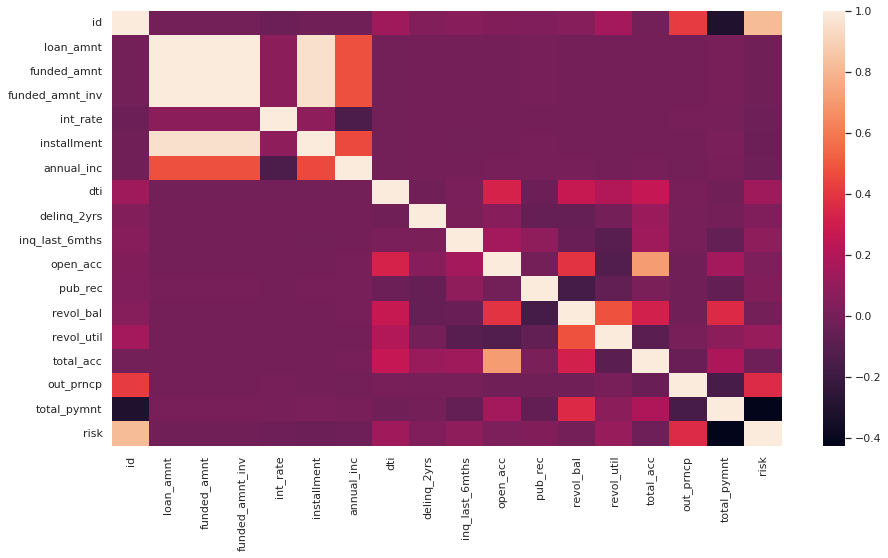

In [78]:
corr_matrix = data.corr(method = 'spearman')
# Я посмотрела разные methods но они все в принципе одинаковые

plt.figure(figsize = (15, 8))
sns.heatmap(corr_matrix.T)

plt.show()

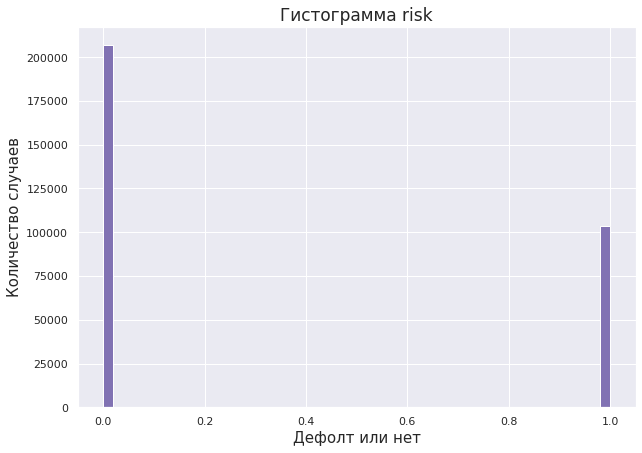

In [79]:
plt.ticklabel_format(style='plain')
data['risk'].hist(bins=50, facecolor='m', figsize=(10, 7))

plt.title('Гистограмма risk', size = 17)
plt.xlabel('Дефолт или нет', size = 15)
plt.ylabel('Количество случаев', size = 15)
plt.show()

Важно было убедиться, что у нас достаточное количество дефолтов для исследования и разница между признаками не превышает 70%.

Посмотрим на распределение loan_amnt

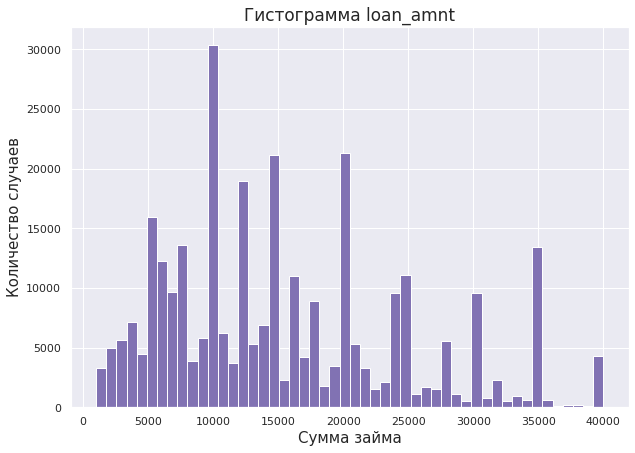

In [80]:
plt.ticklabel_format(style='plain')
data['loan_amnt'].hist(bins=50, facecolor='m', figsize=(10, 7))

plt.title('Гистограмма loan_amnt', size = 17)
plt.xlabel('Сумма займа', size = 15)
plt.ylabel('Количество случаев', size = 15)
plt.show()

Сложно тут оценивать выбросы, потому что в принципе сумма займа не должна сильно зависеть от вероятности дефолта, поэтому пока оставлю так

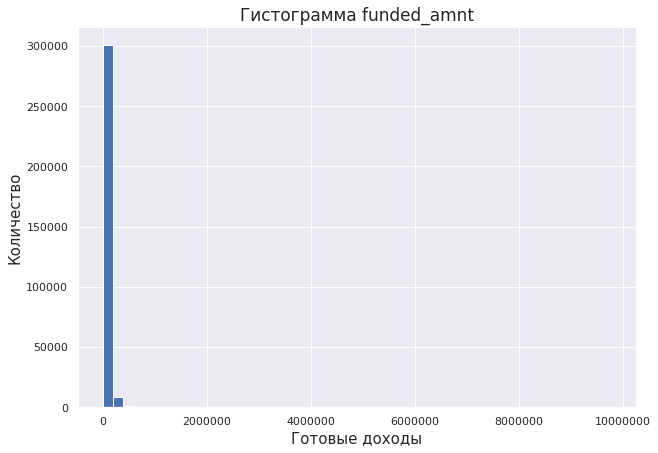

In [81]:
plt.ticklabel_format(style='plain')
data['annual_inc'].hist(bins=50, figsize=(10, 7))

plt.title('Гистограмма funded_amnt', size = 17)
plt.xlabel('Готовые доходы', size = 15)
plt.ylabel('Количество', size = 15)
plt.show()

Видимо есть какие-то выбросы, посмотрю поближе

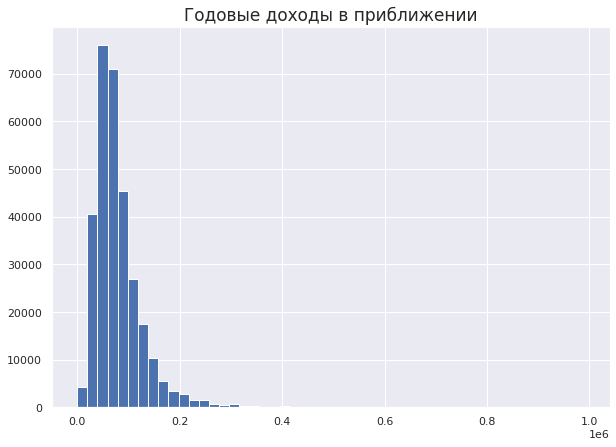

In [82]:
data[data['annual_inc'] < 1000000]['annual_inc'].hist(bins=50, figsize=(10, 7))

plt.title('Годовые доходы в приближении', size = 17)
plt.show()

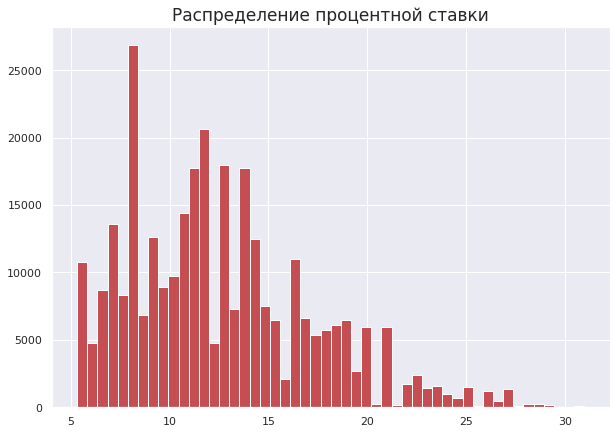

In [83]:
data['int_rate'].hist(color = 'r', bins=50, figsize=(10, 7))

plt.title('Распределение процентной ставки', size = 17)
plt.show()

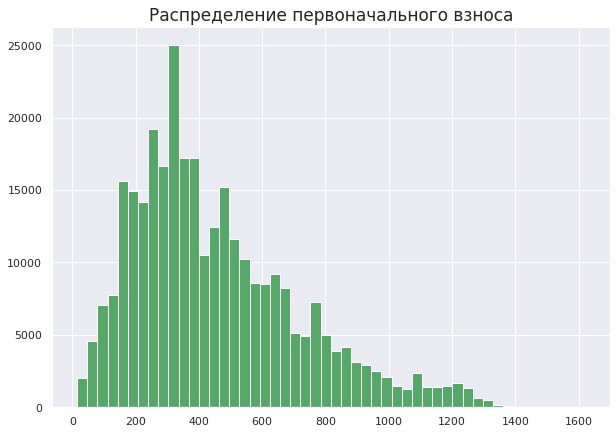

In [84]:
data['installment'].hist(color = 'g', bins=50, figsize=(10, 7))

plt.title('Распределение первоначального взноса', size = 17)
plt.show()

Посмотрим на пропущенные данные:

In [85]:
data.isna().sum()

id                         0
loan_amnt                  0
funded_amnt                0
funded_amnt_inv            0
term                       0
int_rate                   0
installment                0
grade                      0
emp_title              29565
emp_length             22615
home_ownership             0
annual_inc                 0
verification_status        0
issue_d                    0
purpose                    0
addr_state                 0
dti                      148
delinq_2yrs                0
earliest_cr_line           0
inq_last_6mths             1
open_acc                   0
pub_rec                    0
revol_bal                  0
revol_util               213
total_acc                  0
out_prncp                  0
total_pymnt                0
loan_status                0
risk                       0
dtype: int64

In [86]:
data.drop('pub_rec', axis=1, inplace=True) 
# не поняли что это

In [87]:
data['emp_title']

0                                             Chef
1                                      Postmaster 
2                                   Administrative
3                                    IT Supervisor
4                                         Mechanic
                            ...                   
310699                                     Analyst
310700                                     DENTIST
310701                                   Director 
310702    Certified Occupational Therapy Assistant
310703                          Principal Engineer
Name: emp_title, Length: 310704, dtype: object

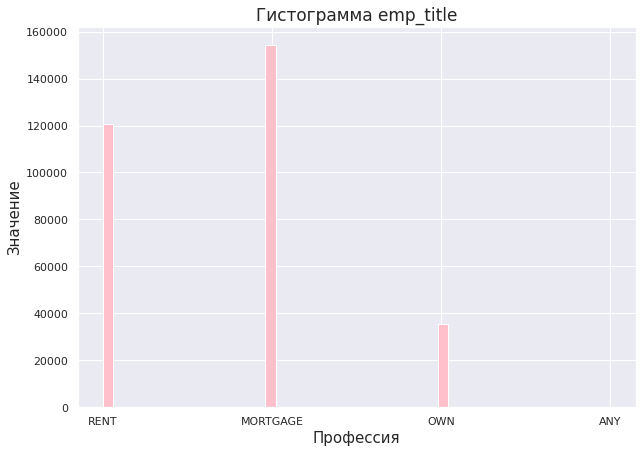

In [88]:
plt.ticklabel_format(style='plain')
data['home_ownership'].hist(bins=50, color='pink', figsize=(10, 7))

plt.title('Гистограмма emp_title', size = 17)
plt.xlabel('Профессия', size = 15)
plt.ylabel('Значение', size = 15)
plt.show()

Возможно на категориальных данных, которых сравнительно меньше остальных, модель будет сильно переобучаться, поэтому я думаю удалю "ANY"

In [89]:
data = data.drop(np.where(data['home_ownership'] == "ANY")[0])

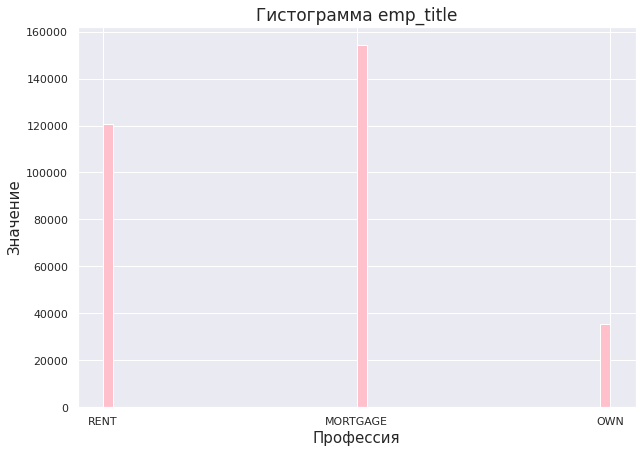

In [90]:
plt.ticklabel_format(style='plain')
data['home_ownership'].hist(bins=50, facecolor='pink', figsize=(10, 7))

plt.title('Гистограмма emp_title', size = 17)
plt.xlabel('Профессия', size = 15)
plt.ylabel('Значение', size = 15)
plt.show()

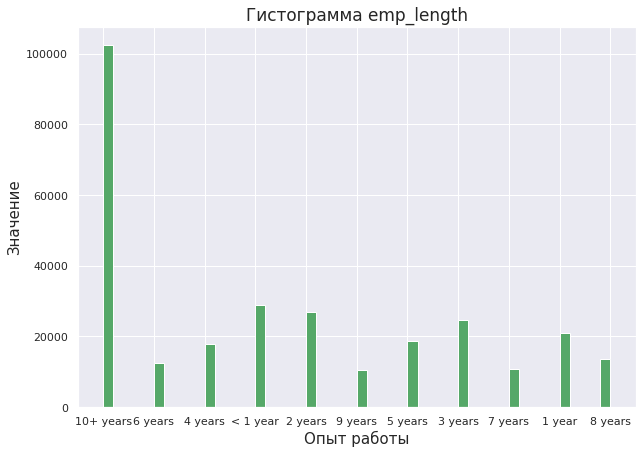

In [91]:
plt.ticklabel_format(style='plain')
data['emp_length'].hist(bins=50, facecolor='g', figsize=(10, 7))

plt.title('Гистограмма emp_length', size = 17)
plt.xlabel('Опыт работы', size = 15)
plt.ylabel('Значение', size = 15)
plt.show()

Так как меньше 10% признаков в emp_title и  emp_lenght пропущены, не будем выкидывать эти признаки, а просто заменим значения пустой строкой.

In [92]:
data.fillna(value={'emp_title': ''}, inplace = True)

Ниже с **emp_length** надо подумать, может лучше сделать просто количество лет и не делать это категориальным признаком

In [93]:
data['emp_length'].unique()

array(['10+ years', '6 years', '4 years', '< 1 year', '2 years',
       '9 years', nan, '5 years', '3 years', '7 years', '1 year',
       '8 years'], dtype=object)

In [94]:
data.fillna(value={'emp_length': 'No'}, inplace = True)

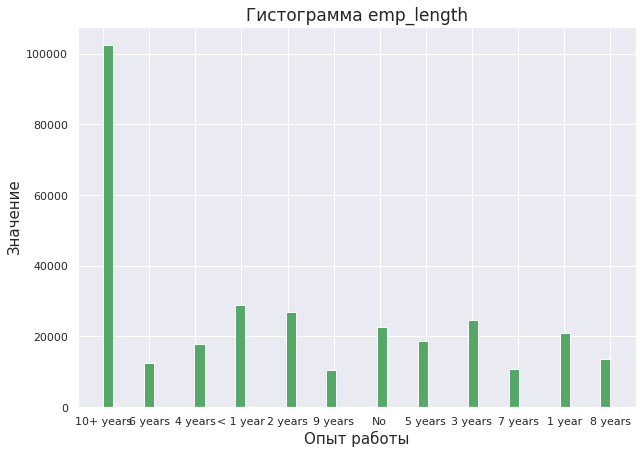

In [95]:
plt.ticklabel_format(style='plain')
data['emp_length'].hist(bins=50, facecolor='g', figsize=(10, 7))

plt.title('Гистограмма emp_length', size = 17)
plt.xlabel('Опыт работы', size = 15)
plt.ylabel('Значение', size = 15)
plt.show()

Мне кажется один из важнейших признаков который должен очень сильно коррелировать - это процент с дохода, который идет на выплату. Очень красивое распределение

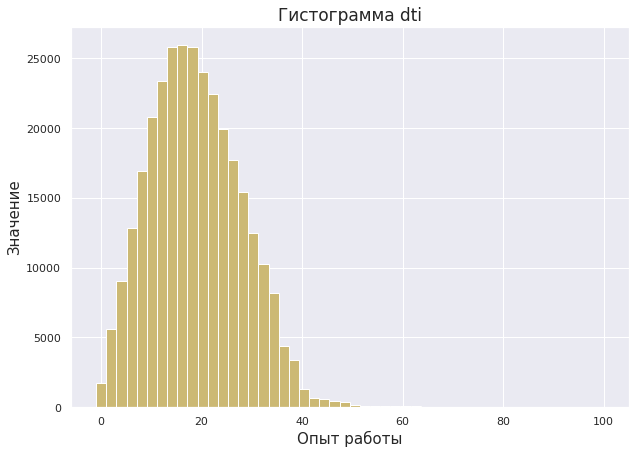

In [96]:
plt.ticklabel_format(style='plain')
# plt.plot(data['dti'], )
# data['dti'].hist(bins=50, facecolor='g', figsize=(10, 7))
data[data['dti'] < 100]['dti'].hist(bins=50, color='y', figsize=(10, 7))

plt.title('Гистограмма dti', size = 17)
plt.xlabel('Опыт работы', size = 15)
plt.ylabel('Значение', size = 15)
plt.show()

In [97]:
data.fillna(value={'dti': 0, 'revol_util': 0}, inplace = True)

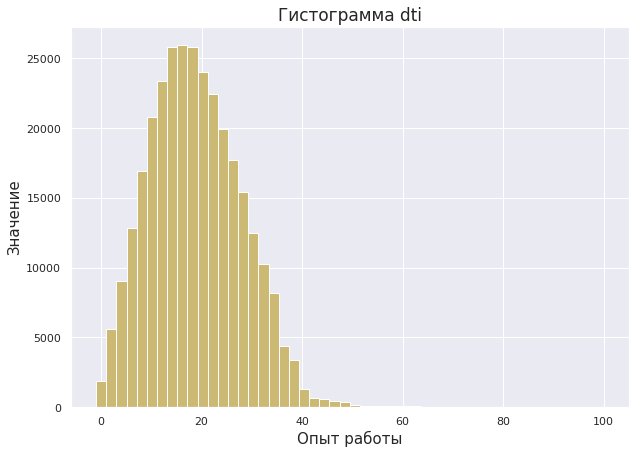

In [98]:
plt.ticklabel_format(style='plain')
# plt.plot(data['dti'], )
# data['dti'].hist(bins=50, facecolor='g', figsize=(10, 7))
data[data['dti'] < 100]['dti'].hist(bins=50, color='y', figsize=(10, 7))

plt.title('Гистограмма dti', size = 17)
plt.xlabel('Опыт работы', size = 15)
plt.ylabel('Значение', size = 15)
plt.show()

Заполнение нулями ничего сильно не повредило, поэтому супер.

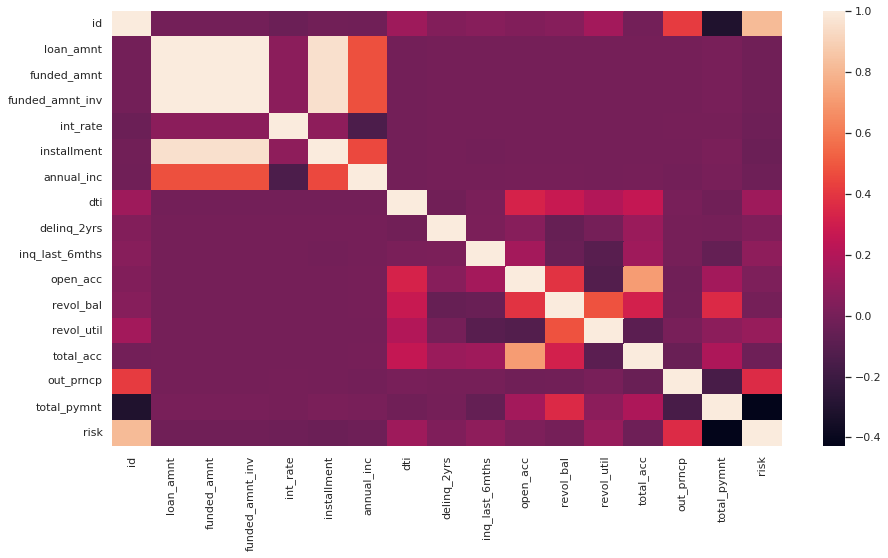

In [99]:
corr_matrix = data.corr(method = 'spearman')

plt.figure(figsize = (15, 8), )
sns.heatmap(corr_matrix.T)

plt.show()

После обработки не особо изменилась корреляция, но попробуем обучиться на половине признаков и посмотреть что будет.

In [114]:
categorical = ['term', 'grade', 'emp_title', 'emp_length', 'home_ownership']
numeric_features = ['loan_amnt', 'int_rate', 'funded_amnt', 'funded_amnt_inv', 'installment', 'dti']

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric_features)
])

pipeline = Pipeline(steps = [
    ('ohe_and_scaling', column_transformer),
    ('regression', Ridge())
])

x = data[['term', 'grade', 'emp_title', 'emp_length', 'home_ownership', 'loan_amnt', 
         'funded_amnt', 'funded_amnt_inv', 'int_rate', 'installment', 'dti', 'out_prncp']]

y = data['risk']

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=10)

model = pipeline.fit(X_train, y_train)

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)


print("Train RMSE = %.4f" % mean_squared_error(y_train, y_pred_train, squared=False))
print("Test RMSE = %.4f" % mean_squared_error(y_test, y_pred_test, squared=False))

Train RMSE = 0.3798
Test RMSE = 0.4460


## Продолжаем обработку данных и попробуем добавить новые признаки (еще пишу)

Два признака с датами, которые возможно стоит перевести в data type, но не разобралась пока что они значат. 

In [100]:
data['issue_d'].unique()

array(['Dec-18', 'Nov-18', 'Oct-18', 'Mar-16', 'Feb-16', 'Jan-16',
       'Nov-15', 'Dec-15', 'Oct-15'], dtype=object)

In [ ]:
data['issue_d'] = pd.to_datetime(data['issue_d'], format='%b-%y')
data['earliest_cr_line'] = pd.to_datetime(data['issue_d'], format='%b-%y')

In [ ]:
data['earliest_cr_line'].unique()

array(['2018-12-01T00:00:00.000000000', '2018-11-01T00:00:00.000000000',
       '2018-10-01T00:00:00.000000000', '2016-03-01T00:00:00.000000000',
       '2016-02-01T00:00:00.000000000', '2016-01-01T00:00:00.000000000',
       '2015-11-01T00:00:00.000000000', '2015-12-01T00:00:00.000000000',
       '2015-10-01T00:00:00.000000000'], dtype='datetime64[ns]')

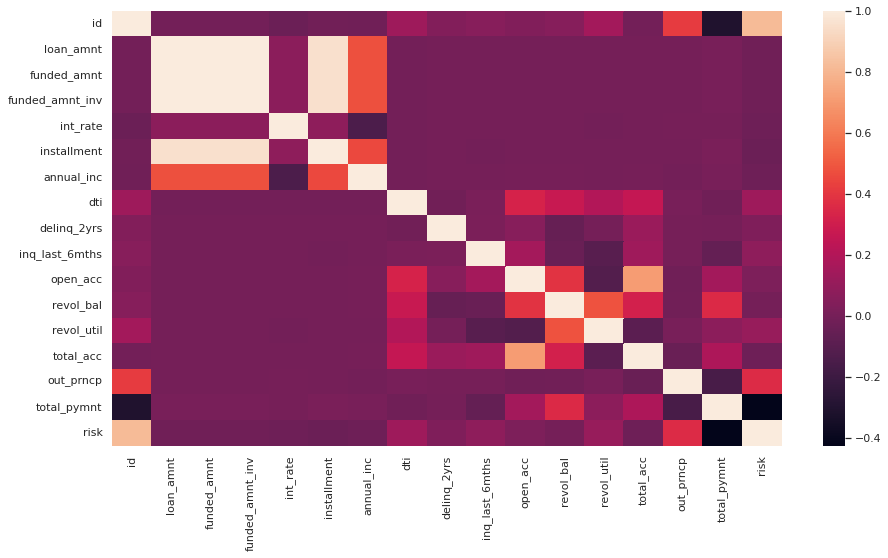

In [ ]:
corr_matrix = data.corr(method = 'spearman')

plt.figure(figsize = (15, 8))
sns.heatmap(corr_matrix.T)

plt.show()

Text(0, 0.5, 'earliest_cr_line')

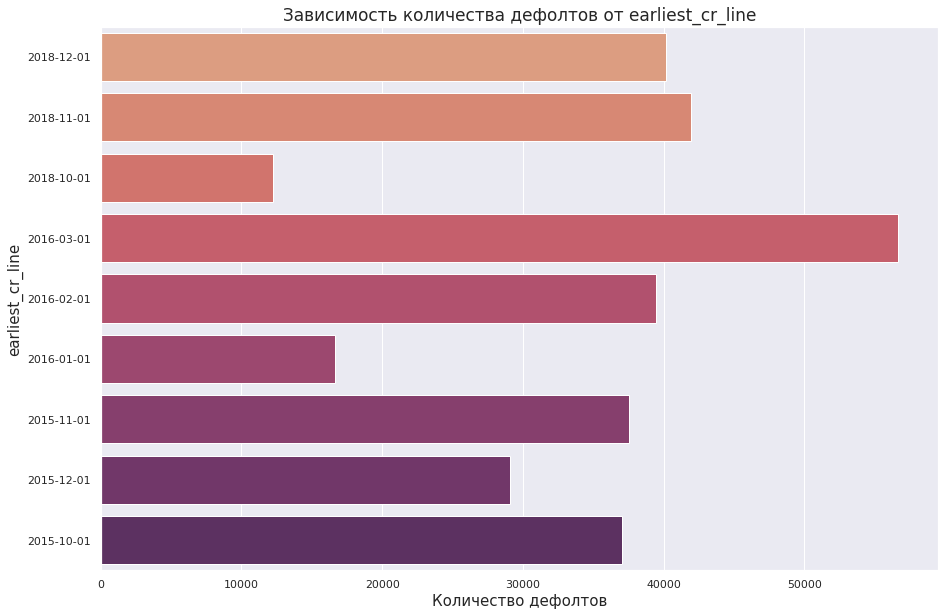

In [ ]:
plt.figure(figsize=(15, 10))
sns.countplot(data = data, y = data['earliest_cr_line'].dt.date, palette="flare")

plt.title('Зависимость количества дефолтов от earliest_cr_line', size = 17)
plt.xlabel('Количество дефолтов', size = 15)
plt.ylabel('earliest_cr_line', size = 15)

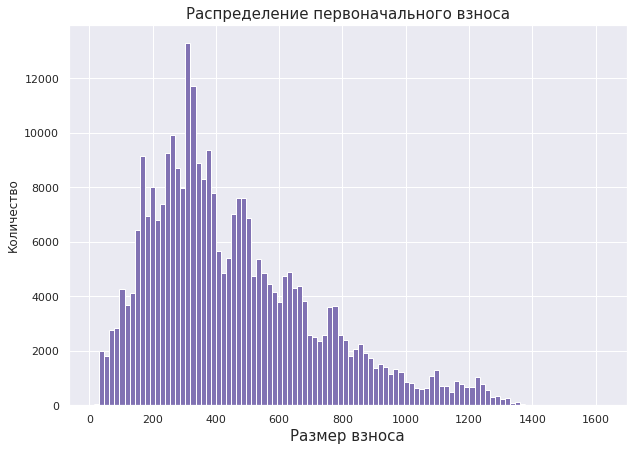

In [ ]:
data['installment'].hist(bins=100, facecolor='m', figsize=(10, 7))
plt.title('Распределение первоначального взноса', size = 15)
plt.xlabel('Размер взноса', size = 15)
plt.ylabel('Количество', size = 12)

plt.show()

Риск дефолта или очень поздного погашения в зависимости от опыта работы:

In [ ]:
data['loan_status'].unique()

array(['Fully Paid', 'Charged Off', 'Default', 'In Grace Period',
       'Late (16-30 days)', 'Late (31-120 days)'], dtype=object)

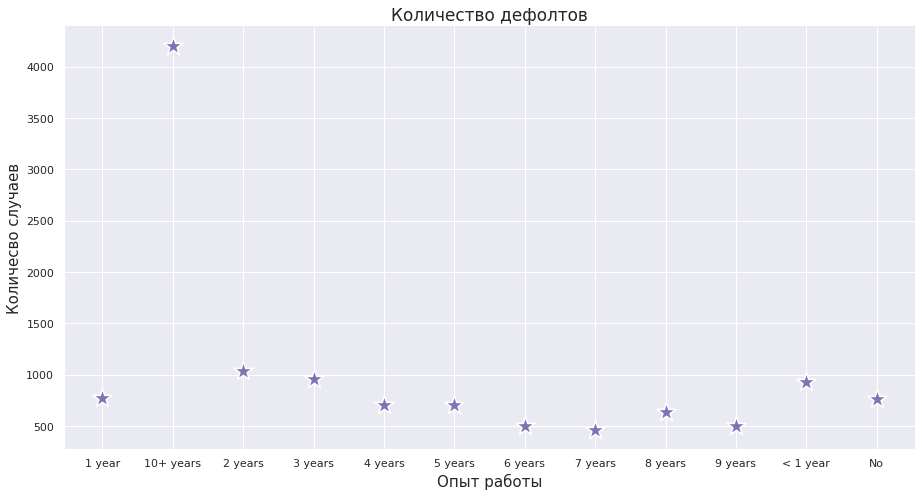

In [ ]:
answ = data.loc[(data['loan_status'] == 'Default') | (data['loan_status'] == 'Late (31-120 days)')]
ax = sns.relplot(data = answ.groupby('emp_length').count()['loan_status'], marker="*", color="m", s = 400)

plt.title('Количество дефолтов', size = 17)
plt.xlabel('Опыт работы', size = 15)
plt.ylabel('Количесво случаев', size = 15)
ax.fig.set_size_inches(15, 7)

## Ridge-регрессия с параметрами по умолчанию


Закодируем через OneHot все категориальные и отмасштабируем часть численных:

In [ ]:
data.head()

,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,emp_title,emp_length,...,earliest_cr_line,inq_last_6mths,open_acc,revol_bal,revol_util,total_acc,out_prncp,total_pymnt,loan_status,risk
0,1,2500,2500,2500.0,36,13.56,84.92,C,Chef,10+ years,...,2018-12-01,0.0,11,15603,37.0,19,0.0,30026.442500,Fully Paid,0
1,2,30000,30000,30000.0,60,18.94,777.23,D,Postmaster,10+ years,...,2018-12-01,0.0,18,34971,64.5,37,0.0,40856.678960,Fully Paid,0
2,3,5000,5000,5000.0,36,17.97,180.69,D,Administrative,6 years,...,2018-12-01,0.0,9,25416,29.9,19,0.0,20215.792430,Fully Paid,0
3,4,4000,4000,4000.0,36,18.94,146.51,D,IT Supervisor,10+ years,...,2018-12-01,0.0,12,4472,15.3,25,0.0,4549.217149,Fully Paid,0
4,5,30000,30000,30000.0,60,16.14,731.78,C,Mechanic,10+ years,...,2018-12-01,0.0,21,36812,65.7,37,0.0,8735.148975,Fully Paid,0


In [ ]:
# categorical = ['emp_title', 'home_ownership', 'purpose', 'verification_status',  'addr_state', 'loan_status']
# numeric_features = ['loan_amnt', 'installment']

In [ ]:
categorical = ['emp_title', 'home_ownership', 'verification_status', 'emp_length']
numeric_features = ['loan_amnt', 'installment']

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric_features)
])

pipeline = Pipeline(steps = [
    ('ohe_and_scaling', column_transformer),
    ('regression', Ridge())
])

In [ ]:
x = data.drop(columns = ['risk'])
y = data['risk']

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=10)

In [ ]:
model = pipeline.fit(X_train, y_train)

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)


print("Train RMSE = %.4f" % mean_squared_error(y_train, y_pred_train, squared=False))
print("Test RMSE = %.4f" % mean_squared_error(y_test, y_pred_test, squared=False))

Train RMSE = 0.3992
Test RMSE = 0.4693


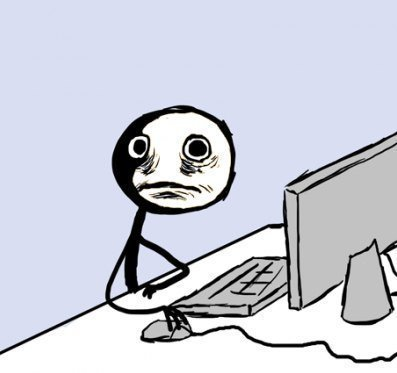